In [ ]:
# Ch 12-3 Food Properties

In [3]:
# Get example file
# Download the E. coli proteome from UniProt
! wget https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000000625/UP000000625_83333.fasta.gz

# Uncompress the file
! gunzip UP000000625_83333.fasta.gz

# Rename it to match the example in the code
! mv UP000000625_83333.fasta example_organism.fasta

--2025-03-22 19:31:46--  https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Bacteria/UP000000625/UP000000625_83333.fasta.gz
128.175.240.195niprot.org (ftp.uniprot.org)... 
connected. to ftp.uniprot.org (ftp.uniprot.org)|128.175.240.195|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 989984 (967K) [application/x-gzip]
Saving to: ‘UP000000625_83333.fasta.gz’

UP000000625_83333.f 100%[===================>] 966.78K  2.14MB/s    in 0.4s    

2025-03-22 19:31:47 (2.14 MB/s) - ‘UP000000625_83333.fasta.gz’ saved [989984/989984]



In [4]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
from collections import Counter

def calculate_food_properties(proteome_file, output_file=None):
    """
    Calculate nutritional properties from a proteome file (FASTA format)
    
    Parameters:
    -----------
    proteome_file : str
        Path to the FASTA file containing protein sequences
    output_file : str, optional
        Path to save the detailed analysis results
    
    Returns:
    --------
    dict
        Dictionary containing nutritional properties
    """
    # Essential amino acids (cannot be synthesized by humans)
    essential_aas = {'F': 'Phenylalanine', 
                    'I': 'Isoleucine', 
                    'K': 'Lysine',
                    'L': 'Leucine', 
                    'M': 'Methionine', 
                    'T': 'Threonine',
                    'V': 'Valine', 
                    'W': 'Tryptophan', 
                    'H': 'Histidine'}
    
    # Non-essential amino acids (can be synthesized by humans)
    non_essential_aas = {'A': 'Alanine', 
                        'R': 'Arginine', 
                        'N': 'Asparagine',
                        'D': 'Aspartic acid', 
                        'C': 'Cysteine', 
                        'E': 'Glutamic acid',
                        'Q': 'Glutamine', 
                        'G': 'Glycine', 
                        'P': 'Proline',
                        'S': 'Serine', 
                        'Y': 'Tyrosine'}
    
    # Amino acid properties
    aa_properties = {
        # Hydrophobic amino acids
        'hydrophobic': ['A', 'I', 'L', 'M', 'F', 'V', 'P', 'G'],
        # Hydrophilic amino acids
        'hydrophilic': ['R', 'N', 'D', 'C', 'Q', 'E', 'H', 'K', 'S', 'T', 'W', 'Y'],
        # Sulfur-containing amino acids (important for flavor)
        'sulfur_containing': ['C', 'M'],
        # Umami taste (savory flavor)
        'umami': ['E', 'G'],
        # Sweet taste
        'sweet': ['A', 'G', 'S', 'T'],
        # Bitter taste
        'bitter': ['I', 'L', 'V', 'F', 'Y', 'W', 'H']
    }
    
    # Read the proteome file
    proteins = list(SeqIO.parse(proteome_file, "fasta"))
    
    # Initialize counters
    total_aa_count = 0
    aa_counter = Counter()
    essential_aa_counter = Counter()
    non_essential_aa_counter = Counter()
    property_counter = {prop: 0 for prop in aa_properties}
    
    # Process each protein
    for protein in proteins:
        sequence = str(protein.seq)
        
        # Count amino acids
        for aa in sequence:
            if aa in essential_aas or aa in non_essential_aas:
                aa_counter[aa] += 1
                total_aa_count += 1
                
                # Count essential and non-essential amino acids
                if aa in essential_aas:
                    essential_aa_counter[aa] += 1
                elif aa in non_essential_aas:
                    non_essential_aa_counter[aa] += 1
                
                # Count properties
                for prop, aa_list in aa_properties.items():
                    if aa in aa_list:
                        property_counter[prop] += 1
    
    # Calculate protein content (g/100g)
    # Assuming average molecular weight of amino acid is 110 g/mol
    # and protein content is roughly 60% of total dry weight
    avg_aa_weight = 110  # g/mol
    protein_content = total_aa_count * avg_aa_weight / 6.022e23 * 100  # g/100g
    
    # Calculate essential amino acid ratio
    essential_ratio = sum(essential_aa_counter.values()) / total_aa_count if total_aa_count > 0 else 0
    
    # Prepare results
    results = {
        "protein_content": protein_content,
        "total_amino_acids": total_aa_count,
        "essential_amino_acid_ratio": essential_ratio,
        "amino_acid_composition": {aa: count/total_aa_count for aa, count in aa_counter.items()},
        "essential_amino_acids": {aa: count for aa, count in essential_aa_counter.items()},
        "non_essential_amino_acids": {aa: count for aa, count in non_essential_aa_counter.items()},
        "taste_properties": {
            prop: count/total_aa_count for prop, count in property_counter.items()
        }
    }
    
    # Calculate nutritional score (based on essential amino acid content)
    essential_aa_importance = {
        'F': 0.8, 'I': 0.9, 'K': 1.0, 'L': 0.9, 'M': 1.0, 
        'T': 0.8, 'V': 0.9, 'W': 1.0, 'H': 0.8
    }
    
    nutritional_score = 0
    for aa, count in essential_aa_counter.items():
        composition = count / total_aa_count if total_aa_count > 0 else 0
        nutritional_score += composition * essential_aa_importance.get(aa, 0)
    
    results["nutritional_score"] = nutritional_score * 10  # Scale to 0-10
    
    # Calculate flavor profile based on amino acid composition
    flavor_profile = {
        "umami": sum(aa_counter[aa] for aa in aa_properties['umami']) / total_aa_count if total_aa_count > 0 else 0,
        "sweet": sum(aa_counter[aa] for aa in aa_properties['sweet']) / total_aa_count if total_aa_count > 0 else 0,
        "bitter": sum(aa_counter[aa] for aa in aa_properties['bitter']) / total_aa_count if total_aa_count > 0 else 0
    }
    
    results["flavor_profile"] = flavor_profile
    
    # Generate a visual representation
    if output_file:
        generate_analysis_report(results, output_file)
    
    return results

def generate_analysis_report(results, output_file):
    """Generate a detailed report with visualizations"""
    # Create a DataFrame for amino acid composition
    aa_data = pd.DataFrame({
        'Amino Acid': list(results['amino_acid_composition'].keys()),
        'Frequency': list(results['amino_acid_composition'].values())
    })
    aa_data = aa_data.sort_values('Frequency', ascending=False)
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Amino acid composition
    axes[0, 0].bar(aa_data['Amino Acid'], aa_data['Frequency'])
    axes[0, 0].set_title('Amino Acid Composition')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Essential vs Non-essential
    essential_count = sum(results['essential_amino_acids'].values())
    non_essential_count = sum(results['non_essential_amino_acids'].values())
    axes[0, 1].pie([essential_count, non_essential_count], 
                  labels=['Essential', 'Non-essential'],
                  autopct='%1.1f%%')
    axes[0, 1].set_title('Essential vs Non-essential Amino Acids')
    
    # Flavor profile
    flavor_data = results['flavor_profile']
    axes[1, 0].bar(flavor_data.keys(), flavor_data.values())
    axes[1, 0].set_title('Flavor Profile')
    axes[1, 0].set_ylabel('Proportion')
    
    # Property distribution
    prop_data = results['taste_properties']
    axes[1, 1].bar(prop_data.keys(), prop_data.values())
    axes[1, 1].set_title('Amino Acid Properties')
    axes[1, 1].set_ylabel('Proportion')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(f"{output_file}_plots.png")
    
    # Generate a summary report
    with open(f"{output_file}_summary.txt", 'w') as f:
        f.write("PROTEOME NUTRITIONAL ANALYSIS\n")
        f.write("============================\n\n")
        f.write(f"Protein Content: {results['protein_content']:.2f} g/100g\n")
        f.write(f"Nutritional Score: {results['nutritional_score']:.2f}/10\n")
        f.write(f"Essential Amino Acid Ratio: {results['essential_amino_acid_ratio']:.2f}\n\n")
        
        f.write("FLAVOR PROFILE\n")
        f.write("=============\n")
        for flavor, value in results['flavor_profile'].items():
            f.write(f"{flavor.capitalize()}: {value:.2f}\n")
        
        f.write("\nESSENTIAL AMINO ACIDS\n")
        f.write("====================\n")
        for aa, count in results['essential_amino_acids'].items():
            f.write(f"{aa}: {count}\n")




Protein Content: 0.00 g/100g
Nutritional Score: 3.94/10
Essential Amino Acid Ratio: 0.44

Flavor Profile:
  Umami: 0.13
  Sweet: 0.28
  Bitter: 0.34


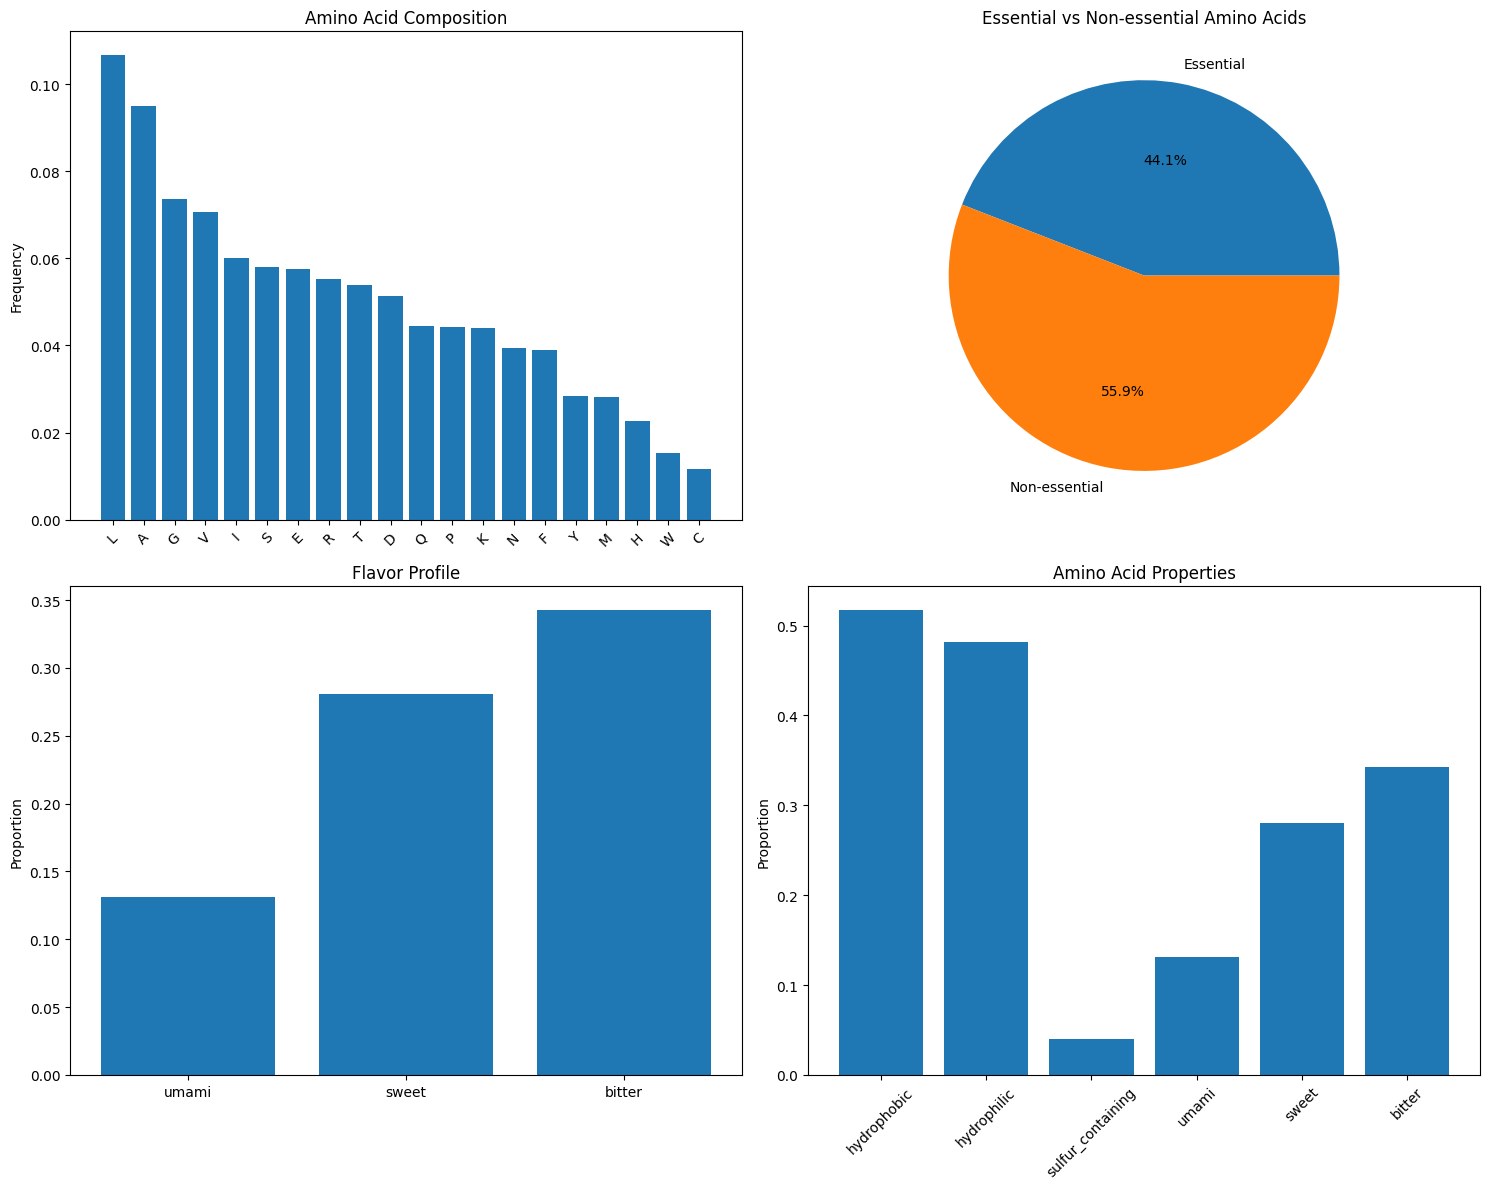

In [5]:
# Example usage
if __name__ == "__main__":
    # Example with a hypothetical proteome file
    # In practice, use a real FASTA file from UniProt or similar source
    proteome_file = "example_organism.fasta"
    results = calculate_food_properties(proteome_file, "nutritional_analysis")
    
    print(f"Protein Content: {results['protein_content']:.2f} g/100g")
    print(f"Nutritional Score: {results['nutritional_score']:.2f}/10")
    print(f"Essential Amino Acid Ratio: {results['essential_amino_acid_ratio']:.2f}")
    
    print("\nFlavor Profile:")
    for flavor, value in results['flavor_profile'].items():
        print(f"  {flavor.capitalize()}: {value:.2f}")